# Training a YOLOv8-based object detector to detect bottles and cans in images

Command for running jupyter notebook on Nvidia Jetson:

`sudo docker run -it --rm --runtime nvidia -e LD_PRELOAD='/usr/lib/aarch64-linux-gnu/libgomp.so.1' --network host nvcr.io/nvidia/l4t-ml:r35.2.1-py3`

The LD_PRELOAD env variable must be set to avoid error

Warning:  Default Python 3 version on Jetson L4T may not be recent enough - this notebook requires at least Python 3.9

This code is partly derived from Keras documentation - e.g.:  https://keras.io/examples/vision/yolov8/

In [ ]:
# Install pre-reqs (specifically as needed for l4t-ml container)
!pip3 install tqdm
!pip3 install tensorflow
!pip3 install --upgrade git+https://github.com/keras-team/keras-cv -q
!pip3 install --upgrade "git+https://github.com/ppwwyyxx/cocoapi.git#egg=pycocotools&subdirectory=PythonAPI" -q
!pip3 install onnx tf2onnx
# Make sure LD_PRELOAD is set correctly
!echo $LD_PRELOAD

In [2]:
# Python >3.9 is required
import platform
print(platform.python_version())

3.10.12


In [ ]:
import os
from tqdm.auto import tqdm

import tensorflow as tf

from tensorflow import keras
# In case of "ValueError: keras_cv>load has already been registered to ..."
keras.utils.get_custom_objects().clear()

import keras_cv
from keras_cv import bounding_box
from keras_cv import visualization

import onnx
#import tf2onnx

import datetime


In [4]:
# Hyperparameters
# SPLIT_RATIO:     Validation split of dataset
# BATCH_SIZE:      The number of images to process before updating the model's weights
# LEARNING_RATE:   The rate at which the model's weights are updated
# EPOCH:           The number of times to iterate over the entire dataset
# GLOBAL_CLIPNORM: The maximum value of the gradient for all model weights
# TARGET_SIZE:     The size of images to be used
SPLIT_RATIO = 0.2
BATCH_SIZE = 4
LEARNING_RATE = 0.001
EPOCH = 5
GLOBAL_CLIPNORM = 10.0
TARGET_SIZE = (640, 640)

# Base directory
workdir = "/home/shibley/development/bevnet/"

Define classes & gather the data annotations

In [8]:
# Class names
class_ids = [
    "can",
    "bottle",
]
class_mapping = dict(zip(range(len(class_ids)), class_ids))

# Path to images and annotations
path_images = workdir + "img-yolo-2023-10-15-13:01/imgs/"
path_annot = workdir + "img-yolo-2023-10-15-13:01/annotations/"

# Get all CSV file paths in path_annot and sort them
csv_files = sorted(
    [
        os.path.join(path_annot, file_name)
        for file_name in os.listdir(path_annot)
        if file_name.endswith(".csv")
    ]
)

print(f"Found {len(csv_files)} CSV files.")

Found 688 CSV files.


Parse the annotation files to populate the class & bounding box labels

In [4]:
def parse_annotation(csv_file):
    # File format:
    # class,xmin,ymin,xmax,ymax

    # Extract image name from file path
    image_name = csv_file.split("/")[-1].replace(".csv", ".jpg")
    image_path = os.path.join(path_images, image_name)

    boxes = []
    classes = []
    for line in open(csv_file):

        # Split line by comma
        line_split = line.split(",")
        # Get class name
        cls = line_split[0]
        classes.append(cls)
        # Get bounding box coordinates
        xmin = float(line_split[1])
        ymin = float(line_split[2])
        xmax = float(line_split[3])
        ymax = float(line_split[4])
        boxes.append([xmin, ymin, xmax, ymax])

    class_ids = [
        list(class_mapping.keys())[list(class_mapping.values()).index(cls)]
        for cls in classes
    ]
    return image_path, boxes, class_ids


# Parse all the annotation files
image_paths = []
bbox = []
classes = []
for csv_file in tqdm(csv_files):
    image_path, boxes, class_ids = parse_annotation(csv_file)
    image_paths.append(image_path)
    bbox.append(boxes)
    classes.append(class_ids)

# Print basic dataset stats
print (f"Found {len(image_paths)} images.")
print (f"Found {len(bbox)} bounding boxes.")
print (f"Found {len(classes)} classes.")
print (f"Found {len(class_mapping)} class mappings.")

100%|██████████████████████████████████████████████████████████████████████████████| 688/688 [00:00<00:00, 44911.93it/s]

Found 688 images.
Found 688 bounding boxes.
Found 688 classes.
Found 2 class mappings.


Begin constructing the training & validation datasets

In [6]:
# Convert to ragged tensors
bbox = tf.ragged.constant(bbox)
classes = tf.ragged.constant(classes)
image_paths = tf.ragged.constant(image_paths)

data = tf.data.Dataset.from_tensor_slices((image_paths, classes, bbox))

# Determine the number of validation samples
num_val_images = int(len(csv_files) * SPLIT_RATIO)

# Shuffle the data - setting seed for reproducibility
data = data.shuffle(buffer_size=len(csv_files), seed=42)

# Split the dataset into train and validation sets
val_data = data.take(num_val_images)
train_data = data.skip(num_val_images)

Define how to load & format data

In [7]:
# Dataset loader
def load_dataset(image_path, classes, bbox):
    # Read Image
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    # Specify labels and bounding boxes
    bounding_boxes = {
        "classes": tf.cast(classes, dtype=tf.float32),
        "boxes": bbox,
    }
    return {"images": tf.cast(image, tf.float32), "bounding_boxes": bounding_boxes}

# Convert input dictionary to tuple
def dict_to_tuple(inputs):
    return inputs["images"], inputs["bounding_boxes"]

Additional variation will be introduced by augmenting the data with random mirroring, shearing and scaling of images

In [8]:
# Configure data augmentation
# - Random horizontal flip
# - Random x/y shear (+/- 20%)
# - Jittered resize (scale +/- 30%)
augmenter = keras.Sequential(
    layers=[
        keras_cv.layers.RandomFlip(mode="horizontal", bounding_box_format="xyxy"),
        keras_cv.layers.RandomShear(
            x_factor=0.2, y_factor=0.2, bounding_box_format="xyxy"
        ),
        keras_cv.layers.JitteredResize(
            target_size=TARGET_SIZE, scale_factor=(0.75, 1.3), bounding_box_format="xyxy"
        ),
    ]
)

# Create the training dataset
train_ds = train_data.map(load_dataset, num_parallel_calls=tf.data.AUTOTUNE)
train_ds = train_ds.shuffle(BATCH_SIZE * 4)
train_ds = train_ds.ragged_batch(BATCH_SIZE, drop_remainder=True)
train_ds = train_ds.map(augmenter, num_parallel_calls=tf.data.AUTOTUNE)
train_ds = train_ds.map(dict_to_tuple, num_parallel_calls=tf.data.AUTOTUNE)
train_ds = train_ds.prefetch(tf.data.AUTOTUNE)

Size of training dataset:  551
Size of training dataset:  551


In [9]:
# Create the validation dataset
# - Jittered resize (scale +/- 30%)
resizing = keras_cv.layers.JitteredResize(
    target_size=TARGET_SIZE,
    scale_factor=(0.75, 1.3),
    bounding_box_format="xyxy",
)

val_ds = val_data.map(load_dataset, num_parallel_calls=tf.data.AUTOTUNE)
val_ds = val_ds.shuffle(BATCH_SIZE * 4)
val_ds = val_ds.ragged_batch(BATCH_SIZE, drop_remainder=True)
val_ds = val_ds.map(resizing, num_parallel_calls=tf.data.AUTOTUNE)
val_ds = val_ds.map(dict_to_tuple, num_parallel_calls=tf.data.AUTOTUNE)
val_ds = val_ds.prefetch(tf.data.AUTOTUNE)

Size of validation dataset:  137
Size of validation dataset:  137


Visualize a sample of images, labels & bounding boxes of each dataset

In [ ]:
# Visualization function
def visualize_dataset(inputs, value_range, rows, cols, bounding_box_format):
    """
    visualize_dataset visualizes the images, labels & bounding boxes 
    for a subset of the data.

    :param inputs: a tensorflow dataset
    :param value_range: pixel value range, e.g. (0, 255)
    :param rows: number of rows in plot
    :param cols: number of columns in plot
    :param bounding_box_format: "xyxy" or "xywh"
    :return: None
    """ 
    images, bounding_boxes = next(iter(inputs.take(1)))
    visualization.plot_bounding_box_gallery(
        images,
        value_range=value_range,
        rows=rows,
        cols=cols,
        y_true=bounding_boxes,
        scale=5,
        font_scale=0.7,
        bounding_box_format=bounding_box_format,
        class_mapping=class_mapping,
    )


visualize_dataset(
    train_ds, bounding_box_format="xyxy", value_range=(0, 255), rows=1, cols=4
)

visualize_dataset(
    val_ds, bounding_box_format="xyxy", value_range=(0, 255), rows=1, cols=4
)

### Configure & compile the model

In [12]:
# We will use yolov8 small backbone with coco weights
backbone = keras_cv.models.YOLOV8Backbone.from_preset(
    "yolo_v8_s_backbone_coco"
)

yolo = keras_cv.models.YOLOV8Detector(
    num_classes=len(class_mapping),
    bounding_box_format="xyxy",
    backbone=backbone,
    fpn_depth=1,
)

optimizer = tf.keras.optimizers.Adam(
    learning_rate=LEARNING_RATE,
    global_clipnorm=GLOBAL_CLIPNORM,
)

yolo.compile(
    optimizer=optimizer, classification_loss="binary_crossentropy", box_loss="ciou"
)

### Specify the callback function

Note:  Currently, COCO metrics is producing errors. The code is commented out until the errors can be resolved. 

In [15]:
class EvaluateCOCOMetricsCallback(keras.callbacks.Callback):
    def __init__(self, data, save_path):
        super().__init__()
        self.data = data
        #self.metrics = keras_cv.metrics.BoxCOCOMetrics(
        #    bounding_box_format="xyxy",
        #    evaluate_freq=1e9,
        #)

        self.save_path = save_path
        self.best_map = -1.0

    def on_epoch_end(self, epoch, logs):
        #self.metrics.reset_state()
        for batch in self.data:
            images, y_true = batch[0], batch[1]
            y_pred = self.model.predict(images, verbose=0)
            #self.metrics.update_state(y_true, y_pred)

        #metrics = self.metrics.result(force=True)
        #logs.update(metrics)

        #current_map = metrics["MaP"]
        #if current_map > self.best_map:
        #    self.best_map = current_map
            self.model.save(self.save_path+"_"+str(epoch)+".keras")  # Save the model when mAP improves

        return logs

### Train the model

In [16]:
# Save the model with a timestamp
timestamp = datetime.datetime.now().strftime("%Y-%m-%d-%H:%M")
# Train the model
yolo.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCH,
    callbacks=[EvaluateCOCOMetricsCallback(val_ds, workdir+"model_"+timestamp)],
)

Epoch 1/5
137/137 [==============================] - 248s 2s/step - loss: 151.8844 - box_loss: 2.1148 - class_loss: 149.7697 - val_loss: 19.9847 - val_box_loss: 3.2338 - val_class_loss: 16.7509
Epoch 2/5
137/137 [==============================] - 233s 2s/step - loss: 3.8281 - box_loss: 1.9494 - class_loss: 1.8788 - val_loss: 3.8424 - val_box_loss: 2.3178 - val_class_loss: 1.5245
Epoch 3/5
137/137 [==============================] - 233s 2s/step - loss: 2.8494 - box_loss: 1.8018 - class_loss: 1.0476 - val_loss: 2.8232 - val_box_loss: 1.8527 - val_class_loss: 0.9705
Epoch 4/5
137/137 [==============================] - 233s 2s/step - loss: 2.3916 - box_loss: 1.6511 - class_loss: 0.7404 - val_loss: 4.4051 - val_box_loss: 2.7887 - val_class_loss: 1.6164
Epoch 5/5
137/137 [==============================] - 233s 2s/step - loss: 2.1663 - box_loss: 1.5336 - class_loss: 0.6327 - val_loss: 2.2038 - val_box_loss: 1.5868 - val_class_loss: 0.6169


### Visualize predictions made with the validation set

1/1 [==============================] - 1s 1s/step


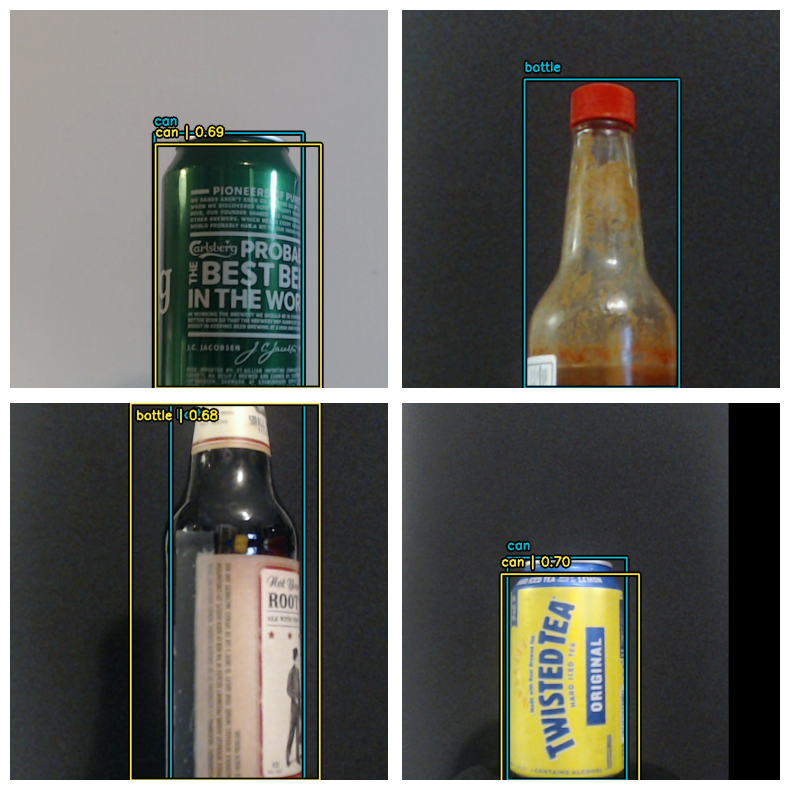

1/1 [==============================] - 0s 355ms/step


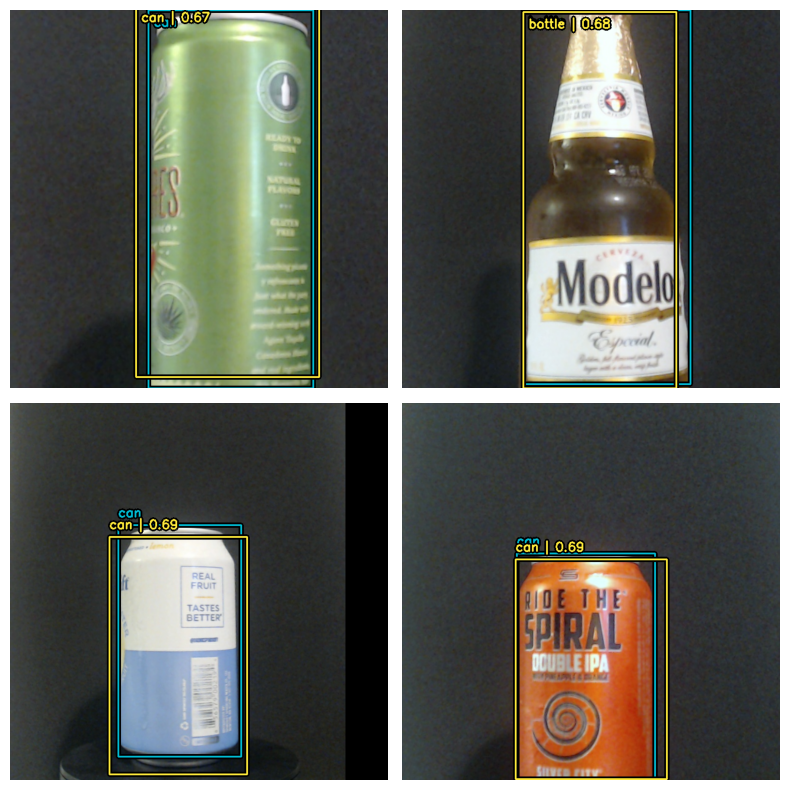

In [36]:

prediction_decoder = keras_cv.layers.MultiClassNonMaxSuppression(
    bounding_box_format="xyxy",
    from_logits=True,
    # Decrease the required threshold to make predictions get pruned out
    iou_threshold=0.1,
    # Tune confidence threshold for predictions to pass NMS
    confidence_threshold=0.65,
)
yolo.prediction_decoder = prediction_decoder

def visualize_detections(model, dataset, bounding_box_format):
    # Get a random batch of images from dataset

    images, y_true = next(iter(dataset.take(1)))
    y_pred = model.predict(images)
    y_pred = bounding_box.to_ragged(y_pred)
    visualization.plot_bounding_box_gallery(
        images,
        value_range=(0, 255),
        bounding_box_format=bounding_box_format,
        y_true=y_true,
        y_pred=y_pred,
        scale=4,
        rows=2,
        cols=2,
        show=True,
        font_scale=0.7,
        class_mapping=class_mapping,
    )


visualize_detections(yolo, dataset=val_ds, bounding_box_format="xyxy")
visualize_detections(yolo, dataset=val_ds, bounding_box_format="xyxy")

### Test the model with a couple of additional test images

1/1 [==============================] - 0s 137ms/step


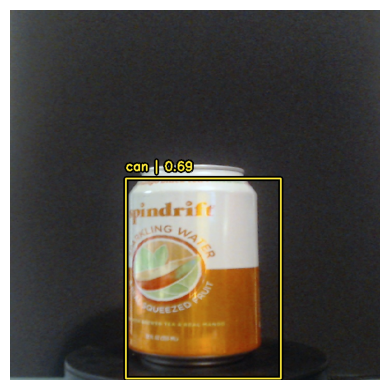

In [40]:
img = keras.preprocessing.image.load_img(
    "img-test/2023-10-13 21:51:40.996404_0.jpg", target_size=TARGET_SIZE
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)

y_pred = yolo.predict(img_array)
y_pred = bounding_box.to_ragged(y_pred)
visualization.plot_bounding_box_gallery(
    img_array,
    value_range=(0, 255),
    bounding_box_format="xyxy",
    y_pred=y_pred,
    scale=4,
    rows=1,
    cols=1,
    show=True,
    font_scale=0.7,
    class_mapping=class_mapping,
)

1/1 [==============================] - 1s 876ms/step


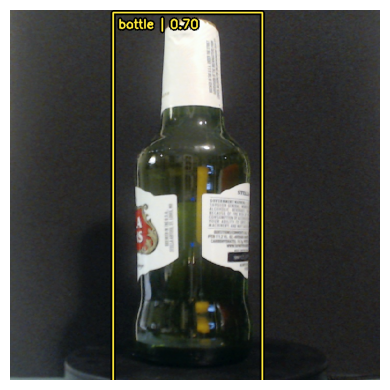

In [56]:
img = keras.preprocessing.image.load_img(
    "img-test/2023-10-13 21:52:12.964904_0.jpg", target_size=TARGET_SIZE
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)

y_pred = yolo.predict(img_array)
y_pred = bounding_box.to_ragged(y_pred)
visualization.plot_bounding_box_gallery(
    img_array,
    value_range=(0, 255),
    bounding_box_format="xyxy",
    y_pred=y_pred,
    scale=4,
    rows=1,
    cols=1,
    show=True,
    font_scale=0.7,
    class_mapping=class_mapping,
)